In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import nbformat
import cv2

from collections import Counter
import logging
import os

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: prince_. Use `wandb login --relogin` to force relogin


True

In [3]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
data_transforms = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "validation": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dir_root, split, transform=None, resize=None):
        self.dir_root = dir_root
        self.split = split
        self.transform = transform
        self.resize = resize
        self.data = []
        self.targets = []
        self.class_names = []

        data_dir = os.path.join(dir_root, split)

        class_directories = sorted(os.listdir(data_dir))
        for class_idx, class_dir in enumerate(class_directories):
            class_path = os.path.join(data_dir, class_dir)
            self.class_names.append(class_dir)

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append(img_path)
                self.targets.append(class_idx)
        
        self.class_idx_to_name = {idx: name for idx, name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data[idx]
        target = self.targets[idx]

        try:
            image = cv2.imread(img_path)

            if self.resize:
                image = cv2.resize(image, (self.resize, self.resize))

            if self.transform:
                image = self.transform(image=image)['image']
            
            return image, target
        
        except Exception as e:
            print(f"Error loading image: {e}")
            return None, None
        
    def num_classes(self):
        return len(self.class_names)
    
    def get_class_name(self, class_idx):
        return self.class_idx_to_name.get(class_idx)
    
    def get_class_names(self):
        return self.class_names
    
    def class_idx_to_name_dict(self):
        return self.class_idx_to_name
    
    def get_classes_frequencies(self):
        return dict(Counter(self.targets))


In [5]:
data_directory = "C:/Users/user/Desktop/analysis/augmented_combined"

In [7]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_directory, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'validation', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

num_classes = len(image_datasets['train'].classes)
print(f"Number of classes: {num_classes}")

{'train': 3093, 'validation': 128, 'test': 130}
['Anthracnose_Fungi', 'Bacterial_Wilt_Bacteria', 'Belly_Rot_Fungi', 'Downy_Mildew_Fungi', 'Gummy_Stem_Blight_Fungi', 'Healthy_Crop_Cucumber', 'Healthy_Crop_Leaf', 'Pythium_Fruit_Rot_Fungi']
Number of classes: 8


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
in_features = model.fc.in_features

model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# for name, param in model.named_parameters():
#     if 'fc' in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

In [13]:
num_epochs = 10
lr = 0.001

model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)

In [14]:
run = wandb.init(
    # Set the project where this run will be logged
    project="milan-project",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "architecture": "resnet18",
        "dataset": "original"
    },
)

In [15]:
wandb.watch(model, log="all")

[]

In [16]:
notebook_name = "NN_resnet18_aug.ipynb"
with open(notebook_name) as f:
    nb = nbformat.read(f, as_version=4)
artifact = wandb.Artifact('notebook', type='notebook')
artifact.add_file(notebook_name)
wandb.log_artifact(artifact)

<Artifact notebook>

In [17]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [18]:
from tqdm import tqdm

def train_one_epoch(epoch, model, dataloader, criterion, optimizer, device):
    model.train()

    # if epoch == 5:
    #     for param in model.parameters():
    #         param.requires_grad = True

    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss/len(dataloader)
    logging.info(f"Epoch: [{epoch+1}], Training Loss: {avg_loss: .4f}")
    return avg_loss

def validation(epoch, model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    logging.info(f"Epoch: [{epoch+1}], Validation Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1


def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix")
    plt.show

    wandb.log({'test loss': avg_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1 score': f1})
    logging.info(f"Test Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1

In [19]:
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, dataloaders['train'], criterion, optimizer, device)
    validation(epoch, model, dataloaders['validation'], criterion, device)

2024-06-06 20:36:55,987 Epoch: [1], Training Loss:  1.0477
2024-06-06 20:37:01,157 Epoch: [1], Validation Loss:  0.8215, Accuracy:  0.6875, Precision:  0.7444, Recall:  0.6875, F1 Score:  0.6785
2024-06-06 20:37:27,860 Epoch: [2], Training Loss:  0.5698
2024-06-06 20:37:32,564 Epoch: [2], Validation Loss:  0.7204, Accuracy:  0.6953, Precision:  0.7426, Recall:  0.6953, F1 Score:  0.6858
2024-06-06 20:38:00,190 Epoch: [3], Training Loss:  0.4624
2024-06-06 20:38:04,906 Epoch: [3], Validation Loss:  0.6930, Accuracy:  0.6875, Precision:  0.7557, Recall:  0.6875, F1 Score:  0.6830
2024-06-06 20:38:30,134 Epoch: [4], Training Loss:  0.4078
2024-06-06 20:38:35,089 Epoch: [4], Validation Loss:  0.6942, Accuracy:  0.7109, Precision:  0.7739, Recall:  0.7109, F1 Score:  0.7069
2024-06-06 20:39:00,918 Epoch: [5], Training Loss:  0.3903
2024-06-06 20:39:05,662 Epoch: [5], Validation Loss:  0.7127, Accuracy:  0.6875, Precision:  0.7576, Recall:  0.6875, F1 Score:  0.6615
2024-06-06 20:39:30,835 E

2024-06-06 20:41:52,593 Test Loss:  0.7788, Accuracy:  0.6846, Precision:  0.7798, Recall:  0.6846, F1 Score:  0.6753


(0.7787867714133527,
 0.6846153846153846,
 0.7798398368057811,
 0.6846153846153846,
 0.6753464570171857)

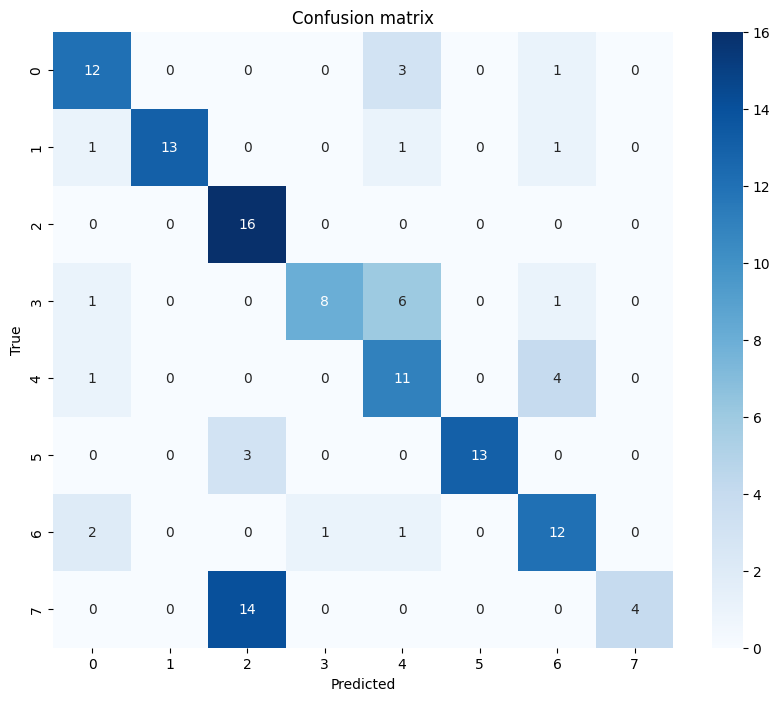

In [20]:
test(model, dataloaders['test'], criterion, device)

In [21]:
model_name = 'resnet18.pth'

torch.save(model.state_dict(), model_name)
model_artifact = wandb.Artifact('model', type='model')
model_artifact.add_file(model_name)

ArtifactManifestEntry(path='resnet18.pth', digest='ZI2EiJn4SJph9xZfuCB2pQ==', size=44801404, local_path='C:\\Users\\user\\AppData\\Local\\wandb\\wandb\\artifacts\\staging\\tmpok6j2s6r', skip_cache=False)

In [22]:
wandb.log_artifact(model_artifact)

<Artifact model>

In [23]:
wandb.finish()

accuracy,▁
f1 score,▁
precision,▁
recall,▁
test loss,▁
accuracy,0.68462
f1 score,0.67535
precision,0.77984
recall,0.68462
test loss,0.77879
